# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Racetrack environment

total reward -1235


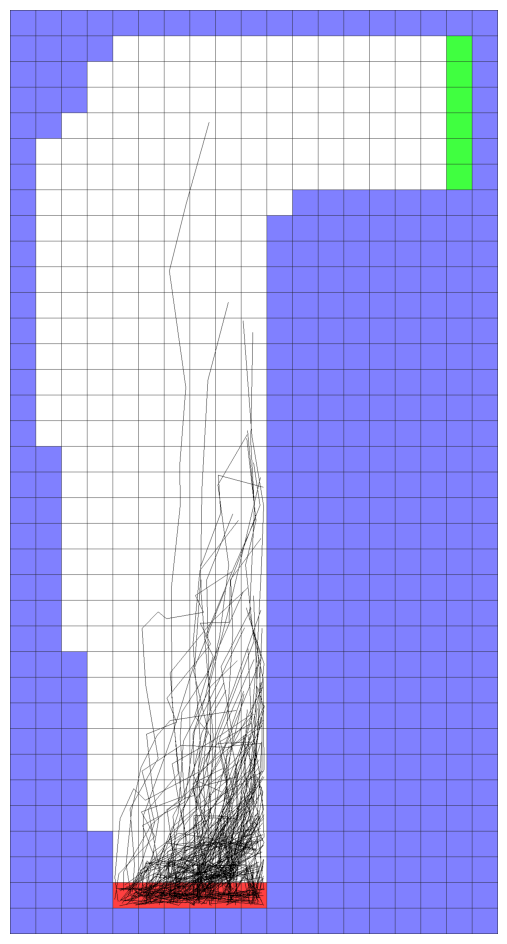

In [41]:
class Racetrack:
    def __init__(self, mode, max_velocity=5):
        self.OFFGRID = -1
        self.ROAD = 0
        self.START = 1
        self.FINISH = 2
        self.MAX_VELOCITY = max_velocity

        if mode == 'easy':
            board = -np.ones((10, 10))
            board[2:-2, 1:-1] = self.ROAD
            board[-2, 1:-1] = self.START
            board[1, 1:-1] = self.FINISH

        elif mode in ['hard', 'medium']:
            board = -np.ones((36, 19))
            for ri, (start, length) in enumerate(
                    [(4, 13), (3, 14), (3, 14), (2, 15), (1, 16), (1, 16), (1, 10)] +
                    [(1, 9) for _ in range(9)] +
                    [(2, 8) for _ in range(8)] +
                    [(3, 7) for _ in range(7)] +
                    [(4, 6), (4, 6)]):
                board[ri + 1, start : start + length] = self.ROAD
            board[-2, 4:10] = self.START
            board[1:7, 17] = self.FINISH
            if mode == 'medium':
                board = np.vstack([board[:10, :], board[-5:, :]])

        else:
            raise Exception(f"Unknown mode `{mode}`")

        self.board = board
        self.start_positions = []
        for r, c in np.ndindex(board.shape):
            if board[r, c] == self.START:
                self.start_positions.append((r, c))

    def render(self, runs):
        """
        Show image with board and run trajectory (if present)
        runs - array of runs, where each run is array of [state0, action0, reward1, state1, action1, reward2, ...]
        state - tuple (pos_row, pos_col, velocity_row, velocity_col)
        """

        board = self.board
        N, M = board.shape
        CELL_SIZE = 64

        img = np.ones((N * CELL_SIZE + 1, M * CELL_SIZE + 1, 3), dtype=np.uint8) * 32

        for r, c in np.ndindex(board.shape):
            colors = {
                self.OFFGRID: [128, 128, 255],
                self.ROAD: [255, 255, 255],
                self.START: [255, 64, 64],
                self.FINISH: [64, 255, 64],
            }
            img[r * CELL_SIZE + 1 : (r + 1) * CELL_SIZE, c * CELL_SIZE + 1 : (c + 1) * CELL_SIZE, :] = colors[board[r, c]]

        for run in runs:
            sar_array = run.sar_array

            shakes = np.random.randint(5, CELL_SIZE - 5, size=((len(sar_array) + 2) // 3, 2))

            for si in range(3, len(sar_array), 3):
                prev_pos_row, prev_pos_col = sar_array[si - 3][0], sar_array[si - 3][1]
                pos_row, pos_col = sar_array[si][0], sar_array[si][1]

                is_reset = 0 <= prev_pos_row < N and 0 <= prev_pos_col < M and 0 <= pos_row < N and 0 <= pos_col < M and (board[prev_pos_row, prev_pos_col] != self.START) and board[pos_row, pos_col] == self.START

                if not is_reset:
                    x1 = prev_pos_col * CELL_SIZE + shakes[si // 3 - 1, 0]
                    y1 = prev_pos_row * CELL_SIZE + shakes[si // 3 - 1, 1]
                    x2 = pos_col * CELL_SIZE + shakes[si // 3, 0]
                    y2 = pos_row * CELL_SIZE + shakes[si // 3, 1]

                    x1 = np.clip(x1, 0, img.shape[1])
                    y1 = np.clip(y1, 0, img.shape[0])
                    x2 = np.clip(x2, 0, img.shape[1])
                    y2 = np.clip(y2, 0, img.shape[0])

                    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 0), thickness=1)

        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        plt.axis('off')

    def check_move(self, pos_row, pos_col, vel_row, vel_col, action_idx):
        """
        Returns (incorrect flag, reset position flag, finish flag)

        incorrect flag - action lead to incorrect car position or velocity, racing needs restart
        reset position flag - car needs to go back to start position
        finish flag - car crossed finish line successfully
        """
        board = self.board
        N, M = board.shape
        MAX_VELOCITY = self.MAX_VELOCITY

        if not (0 <= action_idx < 9) or not (0 <= vel_row < MAX_VELOCITY) or not (0 <= vel_col < MAX_VELOCITY) or not (0 <= pos_row < N and 0 <= pos_col < M):
            return True, False, False

        delta_vel_row, delta_vel_col = action_idx // 3 - 1, action_idx % 3 - 1
        new_vel_row = vel_row + delta_vel_row
        new_vel_col = vel_col + delta_vel_col

        if (new_vel_row == 0 and new_vel_col == 0) or not (0 <= new_vel_row < MAX_VELOCITY) or not (0 <= new_vel_col < MAX_VELOCITY):
            return True, False, False

        for dr, dc in [(0, 1) for _ in range(new_vel_col)] + [(1, 0) for _ in range(new_vel_row)]:
            pos_row -= dr
            pos_col += dc

            if not (0 <= pos_row < N and 0 <= pos_col < M):
                return False, True, False

            if board[pos_row, pos_col] == self.FINISH:
                return False, False, True

            if board[pos_row, pos_col] == self.OFFGRID:
                return False, True, False

        return False, False, False

    def create_trivial_policy(self, type: str):
        board = self.board
        N, M = board.shape
        MAX_VELOCITY = self.MAX_VELOCITY

        if type == 'random':
            policy = np.random.rand(N, M, MAX_VELOCITY, MAX_VELOCITY, 9)
        elif type == 'uniform':
            policy = np.ones((N, M, MAX_VELOCITY, MAX_VELOCITY, 9))
        else:
            raise Exception(f"Unknown type `{type}`")

        for row, col, velrow, velcol, action_idx in np.ndindex(policy.shape):
            incorrect, reset_position, finish = self.check_move(row, col, velrow, velcol, action_idx)
            if incorrect:
                policy[row, col, velrow, velcol, action_idx] = 0
            if action_idx == 8:
                policy[row, col, velrow, velcol, :] /= np.sum(policy[row, col, velrow, velcol, :])

        assert not np.isnan(policy).any()
        return policy

    def generate_run_using_policy(self, policy, stop_episode_when_offroad: bool, max_steps: int, start_pos_idx):
        board = self.board
        N, M = board.shape
        MAX_VELOCITY = self.MAX_VELOCITY
        assert policy.shape == (N, M, MAX_VELOCITY, MAX_VELOCITY, 9)

        run = RacetrackRun(self, start_pos_idx=start_pos_idx, stop_episode_when_offroad=stop_episode_when_offroad)

        pos_row, pos_col, velocity_row, velocity_col = run.reset()

        for step in range(max_steps):
            action_idx = np.random.choice(9, p=policy[pos_row, pos_col, velocity_row, velocity_col, :])

            (pos_row, pos_col, velocity_row, velocity_col), reward, done = run.step(action_idx)

            if done:
                break

        return run

class RacetrackRun:
    def __init__(self, problem: Racetrack, start_pos_idx, stop_episode_when_offroad):
        self.problem = problem
        self.start_positions = problem.start_positions
        self.start_pos_idx = start_pos_idx
        self.stop_episode_when_offroad = stop_episode_when_offroad

        # State is tuple (pos_row, pos_col, velocity_row, velocity_col)
        self.sar_array = []      # Array [state0, action0, reward1, state1, action1, reward2, ...]

    def reset(self):
        if self.start_pos_idx is None:
            start_pos = self.start_positions[np.random.randint(0, len(self.start_positions))]
        else:
            start_pos = self.start_positions[self.start_pos_idx]
        self.sar_array = [(start_pos[0], start_pos[1], 0, 0)]

        return self.sar_array[-1]

    def step(self, action_idx):
        problem = self.problem
        sar_array = self.sar_array
        start_positions = self.start_positions
        stop_episode_when_offroad = self.stop_episode_when_offroad

        pos_row, pos_col, velocity_row, velocity_col = sar_array[-1]

        incorrect, reset_position, finish = problem.check_move(pos_row, pos_col, velocity_row, velocity_col, action_idx)
        if incorrect:
            raise Exception(f"Incorrect action {action_idx} on state {pos_row, pos_col, velocity_row, velocity_col}")

        delta_vel_row, delta_vel_col = action_idx // 3 - 1, action_idx % 3 - 1
        velocity_row += delta_vel_row
        velocity_col += delta_vel_col

        if reset_position:
            pos_row, pos_col = start_positions[np.random.randint(0, len(start_positions))]
            velocity_row, velocity_col = 0, 0
        else:
            pos_row -= velocity_row
            pos_col += velocity_col
        # if problem.board[pos_row, pos_col] == problem.OFFGRID:
        #     print(action_idx, (delta_vel_row, delta_vel_col), (incorrect, reset_position, finish), (pos_row, pos_col, velocity_row, velocity_col))
        if finish:
            pos_row = np.clip(pos_row, 0, problem.board.shape[0] - 1)
            pos_col = np.clip(pos_col, 0, problem.board.shape[1] - 1)
        else:
            assert problem.board[pos_row, pos_col] != problem.OFFGRID

        if reset_position and stop_episode_when_offroad:
            reward = -100
        elif reset_position:
            reward = -2   # let's penalize for reset a bit more
        elif finish:
            reward = 100
        else:
            reward = -1

        next_state = (pos_row, pos_col, velocity_row, velocity_col)

        sar_array.append(action_idx)
        sar_array.append(reward)
        sar_array.append(next_state)

        done = finish or (reset_position and stop_episode_when_offroad)

        return next_state, reward, done

    def get_total_reward(self):
        return np.sum(self.sar_array[2::3])

def show_random_policy():
    problem = Racetrack(mode='hard')
    # problem = Racetrack(mode='medium')
    # problem = Racetrack(mode='easy')
    run = problem.generate_run_using_policy(problem.create_trivial_policy('random'), stop_episode_when_offroad=False, max_steps=1000, start_pos_idx=None)
    problem.render([run])
    print("total reward", run.get_total_reward())

show_random_policy()

# Sarsa (on-policy TD control)

Book "Reinforcement Learning An Introduction" by Sutton and Barto, second edition, page 130, 6.4 - On-policy TD Control

total reward 557


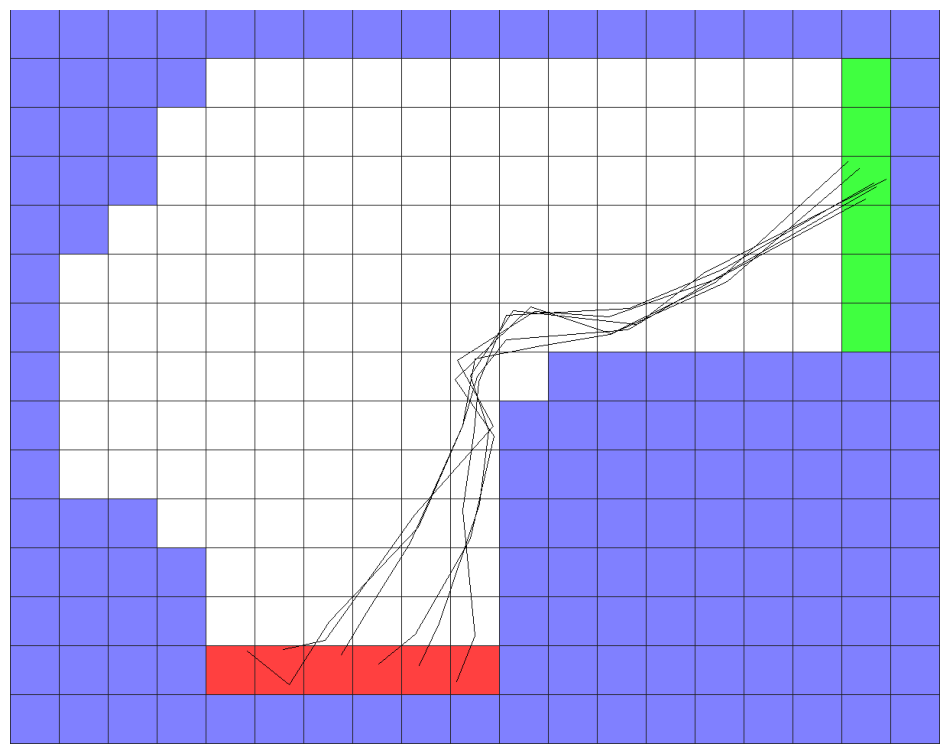

In [43]:
def estimate_optimal_policy__sarsa(problem, stop_episode_when_offroad, learning_rate, discount_factor, max_episodes, max_episode_steps):
    board = problem.board
    N, M = board.shape
    MAX_VELOCITY = problem.MAX_VELOCITY

    q_values = np.random.rand(N, M, MAX_VELOCITY, MAX_VELOCITY, 9)

    uniform_policy = problem.create_trivial_policy('uniform')

    for row, col, velrow, velcol, action_idx in np.ndindex(q_values.shape):
        incorrect, reset_position, finish = problem.check_move(row, col, velrow, velcol, action_idx)
        if finish:
            q_values[row, col, velrow, velcol, action_idx] = 0              # Set terminal states-action to zero
        if incorrect:
            q_values[row, col, velrow, velcol, action_idx] = -np.inf        # Never pick incorrect actions

    epsilon_greedy = 0.1

    def __get_action_with_epsilon_greedy(state):
        if np.random.rand() <= epsilon_greedy:   # Take random valid action
            p = uniform_policy[state[0], state[1], state[2], state[3], :]
            action_idx = np.random.choice(9, p=p)
            # print("random", action_idx)

        else:
            q_s = q_values[state[0], state[1], state[2], state[3], :]
            action_idx = np.argmax(q_s)
            # print("greedy", action_idx, q_s)

        return action_idx

    for episode in range(max_episodes):

        run = RacetrackRun(problem, start_pos_idx=None, stop_episode_when_offroad=stop_episode_when_offroad)

        state = run.reset()

        action_idx = __get_action_with_epsilon_greedy(state)

        for step in range(max_episode_steps):

            next_state, reward, done = run.step(action_idx)

            next_action_idx = __get_action_with_epsilon_greedy(next_state)

            q_s_a_prev = q_values[state[0], state[1], state[2], state[3], action_idx]
            q_s_a_next = q_values[next_state[0], next_state[1], next_state[2], next_state[3], next_action_idx]

            q_values[state[0], state[1], state[2], state[3], action_idx] = q_s_a_prev + learning_rate * (reward + discount_factor * q_s_a_next - q_s_a_prev)

            state = next_state
            action_idx = next_action_idx

            if done:
                break

    policy = np.zeros_like(q_values)
    for row, col, velrow, velcol in np.ndindex((N, M, MAX_VELOCITY, MAX_VELOCITY)):
        policy[row, col, velrow, velcol, np.argmax(q_values[row, col, velrow, velcol])] = 1

    return policy

def solve(mode, max_velocity, max_episodes=5000, max_episode_steps=50):
    problem = Racetrack(mode=mode, max_velocity=max_velocity)
    policy = estimate_optimal_policy__sarsa(problem, stop_episode_when_offroad=False, learning_rate=1e-2, discount_factor=0.99, max_episodes=max_episodes, max_episode_steps=max_episode_steps)

    runs = []
    total_reward = 0
    for start_pos_idx in range(len(problem.start_positions)):
        run = problem.generate_run_using_policy(policy, stop_episode_when_offroad=False, max_steps=200, start_pos_idx=start_pos_idx)
        runs.append(run)
        total_reward += run.get_total_reward()
    problem.render(runs)
    print("total reward", total_reward)

solve('medium', max_velocity=5)

total reward 144


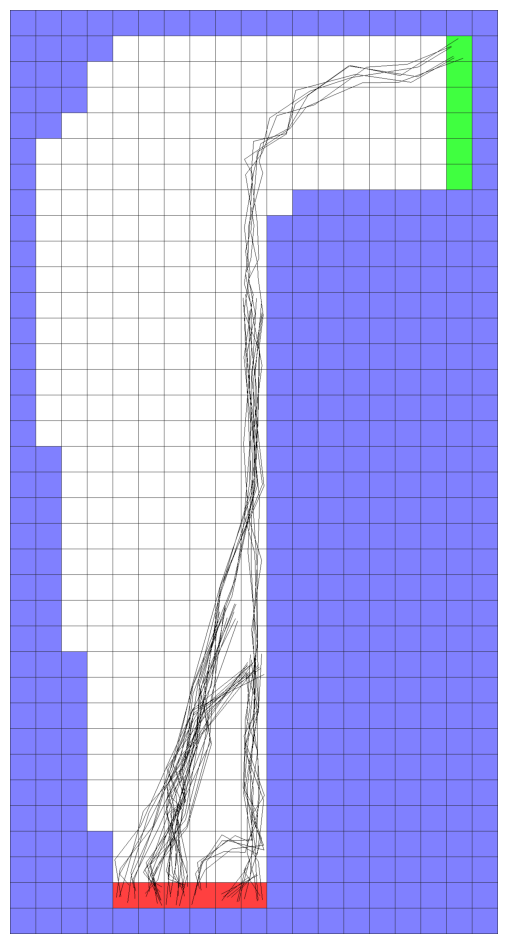

In [44]:
solve('hard', max_velocity=5)